# Exploratory Data Analysis Using Youtube Video Data from the Most Popular City Design Youtube Channels

## 1. Aims, objective and background

### 1.1. Introduction



City design is an important aspect to take into consideration when it comes to deciding about a future job opportunity or a move. It represents not only the means of getting around a city (through the amount of investments poured into public transportation or bike paths) but also measures the level of access to services and jobs. __Fifteen-minute cities__ is a planning concept promoting that most necessities should be reached by a 15-minute walk or bike ride [[1]](https://linkinghub.elsevier.com/retrieve/pii/S2214140518305103).

The evolution of such cities in democratic countries is fully dependent on the support of the public through civil activities such as town hall meetings, discussions with the stakeholders and through voting. The first step for such actions to happen is by increasing the awareness of the concept through the internet.

Youtube continues to be an essential avenue for sharing knowledge, processing more than 3 billion searches per month [[2]](https://www.mushroomnetworks.com/infographics/youtube---the-2nd-largest-search-engine-infographic/). It is, however, difficult to understand how the youtube algorithm works and what makes a video get views or be recommended over another. 

Due to my interest in the evolution of walkable cities throughout the world, I have decided to gain some insights on the topic by analysing 10 popular Youtube channels which focus on public infrastructure and design.



### 1.2. Aims and objectives



Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analysing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?
- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    - Which questions are being asked in the comment sections in the videos

### 1.3. Steps of the project


1. Obtain video meta data via Youtube API for 10 channels in the city design niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

### 1.4. Dataset

#### Data selection

I created my own dataset using the [Google Youtube Data API version 3.0](https://developers.google.com/youtube/v3). The exact steps of data creation is presented in section *2. Data Creation* below.

#### Data limitations



The dataset is a real-world dataset and suitable for the research. However, the selection of the 10 Youtube channels to include in the research is purely based on my knowledge of the channels in the city design field and might not be accurate. My definition is "popular" is based both on subscriber count and personal knowledge but there are other metrics that could be taken into consideration as well (e.g. views, engagement). The top 10 also seems arbitrary given the plethora of channels on Youtube. There might be smaller channels that might also be very interesting to look into, which could be the next step of this project.


#### Ethics of data source



According to [Youtube API's guide](https://developers.google.com/youtube/v3/getting-started), the usage of Youtube API is free of charge given that your application sends requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there are no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

In [7]:
import os
from dotenv import load_dotenv
from os import path
from PIL import Image
from googleapiclient.discovery import build
from IPython.display import JSON
from dateutil import parser
import pandas as pd
import numpy as np
import helper_functions as hf
import re
from datetime import timedelta
from ast import literal_eval

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="darkgrid", color_codes=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import isodate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data creating with Youtube API

I first created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled the Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using their URLs). Then I created the functions for getting the channel statistics via the API.

In [9]:
load_dotenv()

api_key = os.getenv('API_KEY')

channel_ids = [
    'UC0intLFzLaudFG-xAvUEO-A', # https://www.youtube.com/c/NotJustBikes
    'UCGc8ZVCsrR3dAuhvUbkbToQ', # https://www.youtube.com/c/CityBeautiful
    'UCfgtNfWCtsLKutY-BHzIb9Q', # https://www.youtube.com/c/CityNerd
    'UC-LM91jkqJdWFvm9B5G-w7Q', # https://www.youtube.com/c/AlanFisher1337
    'UCK1XzxcKXB_v_dcw_tflC1A', # https://www.youtube.com/c/OBFYT
    'UCTeYrzSQ3YCp3RovGH4y8Ew', # https://www.youtube.com/@strongtowns
    'UCf4iKXL_SJQ5d0qsKkboRRQ', # https://www.youtube.com/@RMTransit
    'UCGUsu81fitNrOjYjuprqFMg', # https://www.youtube.com/@UrbanCyclingInstitute
    'UCpA8SRNrqDpq3Ad7lOCfCLg', # https://www.youtube.com/@AboutHere
    'UC67YlPrRvsO117gFDM7UePg'  # https://www.youtube.com/@BicycleDutch
    ]

youtube = build( "youtube", "v3", developerKey=api_key)

In [1]:
# Helper functions

def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

from ast import literal_eval

def parse_string_to_list(input_str):
    """
    Parse a string representation of a list into an actual list of strings.
    
    Params:
    input_str: A string that is expected to be a representation of a Python list of strings.
    
    Returns:
    A list of strings if the parsing is successful; otherwise, a message indicating the type of error.
    """
    
    try:
        parsed_list = literal_eval(input_str)
        
        if isinstance(parsed_list, list):
            return parsed_list
        else:
            return "The parsed object is not a list."
            
    except (ValueError, SyntaxError):
        return "Invalid string format."

def youtube_duration_to_seconds(duration_str):
    """
    Convert a YouTube video duration string to total seconds.
    
    Params:
    duration_str: A string representing the video duration in YouTube's format (e.g., "PT1H2M3S").
    
    Returns:
    An integer representing the total duration in seconds; or None if the format is invalid.
    """
    pattern = r"PT((\d+)H)?((\d+)M)?((\d+)S)?"
    match = re.match(pattern, duration_str)
    
    if match:
        groups = match.groups()
        
        hours = int(groups[1]) if groups[1] else 0
        minutes = int(groups[3]) if groups[3] else 0
        seconds = int(groups[5]) if groups[5] else 0
        
        total_seconds = timedelta(hours=hours, minutes=minutes, seconds=seconds).total_seconds()
        return total_seconds
    else:
        return None

In [5]:
# Get all the stats from the channels, using helper functions
channel_stats = get_channel_stats(youtube, channel_ids)
video_ids = get_video_ids(youtube, channel_stats['playlistId'][0])
video_df = get_video_details(youtube, video_ids)
comments = get_comments_in_videos(youtube, video_ids)

Could not get comments for video Yo4LrdpP-uE


### Get channel statistics

Using the `get_channel_stats` function defined below, now we are going to obtain the channel statistics for the 10 channels in scope.

In [10]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [11]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,About Here,107000,5902162,17,UUpA8SRNrqDpq3Ad7lOCfCLg
1,Not Just Bikes,1090000,129316598,97,UU0intLFzLaudFG-xAvUEO-A
2,Alan Fisher,214000,20718479,76,UU-LM91jkqJdWFvm9B5G-w7Q
3,CityNerd,195000,15656708,115,UUfgtNfWCtsLKutY-BHzIb9Q
4,BicycleDutch,67700,28446446,999,UU67YlPrRvsO117gFDM7UePg
5,RMTransit,241000,31155161,630,UUf4iKXL_SJQ5d0qsKkboRRQ
6,OBF,506000,81970783,92,UUK1XzxcKXB_v_dcw_tflC1A
7,Urban Cycling Institute,9910,431625,77,UUGUsu81fitNrOjYjuprqFMg
8,City Beautiful,645000,71977840,149,UUGc8ZVCsrR3dAuhvUbkbToQ
9,Strong Towns,85600,2747667,107,UUTeYrzSQ3YCp3RovGH4y8Ew


We will convert the count columns from `channel_stats` in numeric so we can visualize and do numeric operations on them.

In [12]:
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_stats[numeric_cols] = channel_stats[numeric_cols].apply(pd.to_numeric, errors='coerce')

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

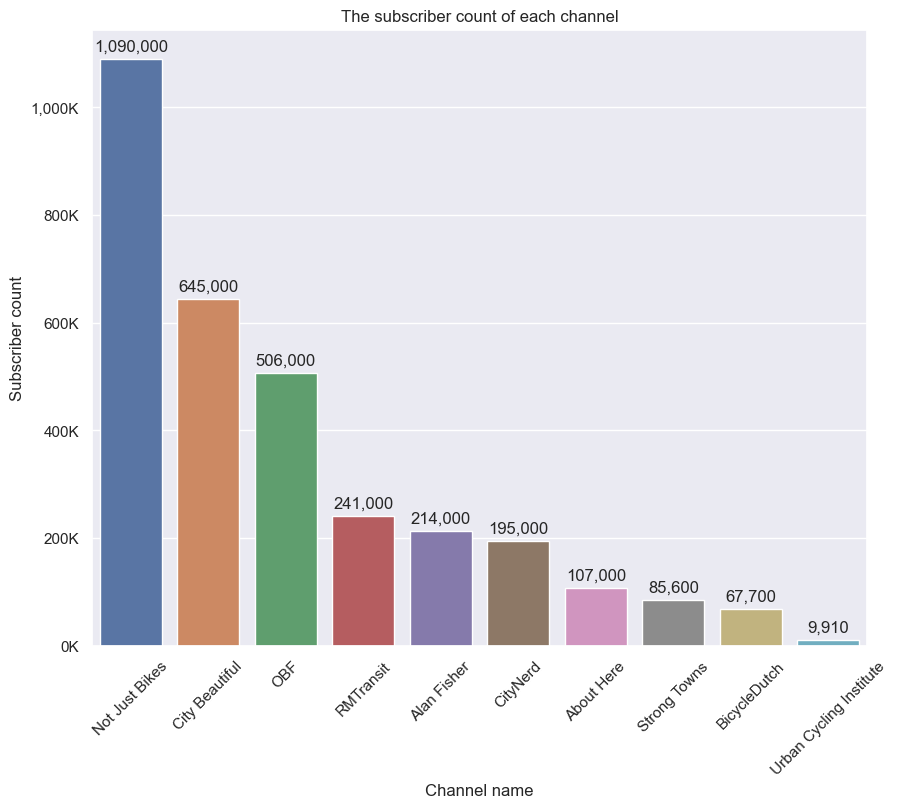

In [21]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
    
ax.set_xlabel("Channel name")
ax.set_ylabel("Subscriber count")

ax.set_title("The subscriber count of each channel")

plt.show()

Next, we will look at the rank considering the total number of views of the channels. The rank is fairly similar to the subscriber count rank. NotJustBikes remains, by far, the most popular channel considering both subscribers and views. On the other hand, interestingly, OBF and City Beautiful switch places in view count. This trend happens multiple times in the top. The last place is still consistent, with the Urban Cycling Institute having the least amount of both subscribers and views.

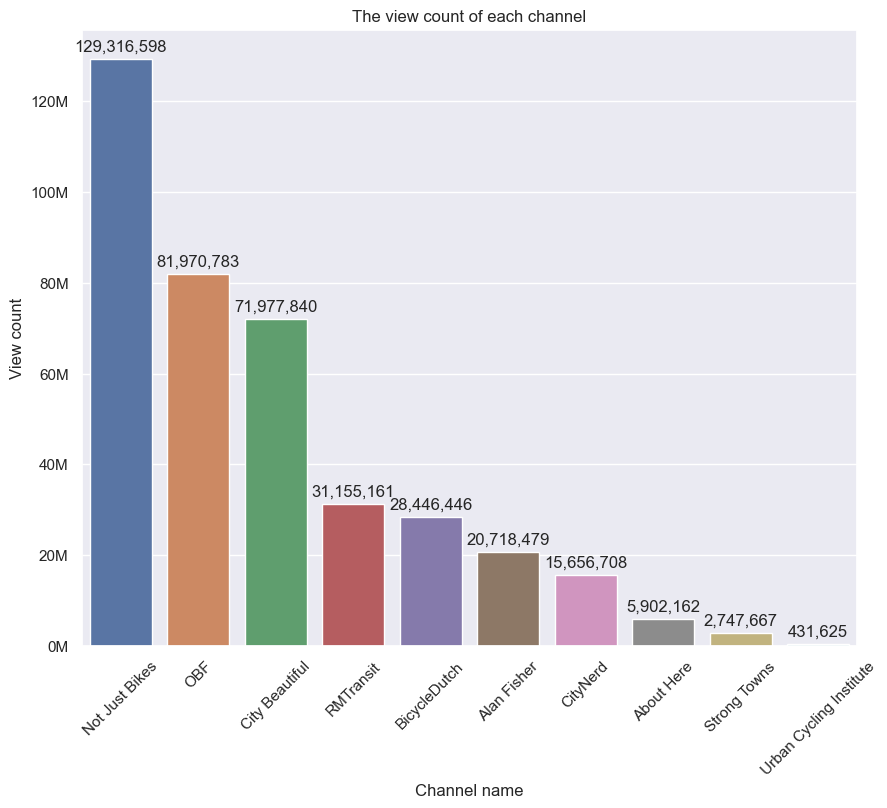

In [28]:
ax = sns.barplot(x='channelName', y='views', data=channel_stats.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
    
ax.set_xlabel("Channel name")
ax.set_ylabel("View count")

ax.set_title("The view count of each channel")

plt.show()

### Get video statistics for all the channels

In the next step, we will obtain the video statistics for all the channels. In total, we obtained 2366 videos as seen below. Certain videos are past or future live-streams without any comments, returning the flag "Could not get comments for video _".

In [30]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_stats['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_stats.loc[channel_stats['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    video_data = get_video_details(youtube, video_ids)
    comments_data = get_comments_in_videos(youtube, video_ids)

    video_df = pd.concat([video_df, video_data], ignore_index=True)
    comments_df = pd.concat([comments_df, comments_data], ignore_index=True)

Getting video information from channel: About Here
Could not get comments for video -NcaZ0G_zO8
Getting video information from channel: Not Just Bikes
Getting video information from channel: Alan Fisher
Could not get comments for video Yo4LrdpP-uE
Getting video information from channel: CityNerd
Could not get comments for video XcoHbt2y0jg
Getting video information from channel: BicycleDutch
Could not get comments for video lvlmOvEHrWM
Could not get comments for video UaDrDRkhhaU
Getting video information from channel: RMTransit
Getting video information from channel: OBF
Could not get comments for video b_Vd_eafLEw
Getting video information from channel: Urban Cycling Institute
Could not get comments for video S-TQp3atSJo
Could not get comments for video 6RBRdfkNYuI
Getting video information from channel: City Beautiful
Getting video information from channel: Strong Towns
Could not get comments for video Dfb9Fg-OhcU


In [50]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,QKz4aikWGcw,About Here,About Here's first merch item,Find these sticker wraps for your transit card...,None,2023-06-24T12:00:18Z,4468.0,222.0,24.0,PT37S,hd,false
1,DqvQ-5784po,About Here,Why did Kids Stop Walking to School?,Thank you so much to @TransLink for partnering...,None,2023-05-04T17:56:46Z,1041255.0,37196.0,6718.0,PT12M39S,hd,false
2,7EYf-S5yTEk,About Here,How Vancouver's Waterfront Became so Boring,Thanks to Urbanarium as always for partnering ...,None,2023-02-14T19:00:02Z,549441.0,18781.0,2120.0,PT10M42S,hd,false
3,sKudSeqHSJk,About Here,The Non-capitalist Solution to the Housing Crisis,Thank you to @vancitycu for sponsoring this vi...,None,2022-11-01T22:27:57Z,923085.0,44382.0,3881.0,PT16M3S,hd,false
4,9YspRX7bbTM,About Here,How to Bring Back Front Yard Businesses,How do we add mixed uses in single detached ne...,"[uytae, front yard businesses, about here, urb...",2022-06-23T01:30:02Z,1225928.0,25717.0,2475.0,PT8M45S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
2361,uFXrJhE8-ZE,Strong Towns,Auto-Oriented Development Is a Huge Experiment...,"The second of our Curbside Chat series, an ey...","[automobiles, urban development, Curbside Chat...",2014-09-15T15:53:47Z,17594.0,483.0,18.0,PT3M,hd,false
2362,vaeaR1fZ4G8,Strong Towns,"Understanding Brainerd, Part 1: The Grid","Brainerd, MN, was built on the traditional gri...",[strong towns brainerd],2013-07-23T22:39:25Z,25220.0,409.0,56.0,PT55M56S,hd,false
2363,F6jFnOnjzrk,Strong Towns,The STROAD,"When you combine a street and a road, you get ...","[strong towns, stroad, transportation, traffic...",2013-03-04T07:48:13Z,77690.0,1543.0,99.0,PT5M16S,hd,false
2364,_-6X1-SLOXM,Strong Towns,"Conversation with an Engineer, Street Project",A resident has a conversation with a project e...,[xtranormal],2010-12-04T17:35:03Z,32710.0,261.0,19.0,PT3M58S,sd,false


We can take a look at the comments as well. We only got 2357 because we also limited to the 10 first comments in order to not exceed the Youtube API quota limit

In [32]:
comments_df

,video_id,comments
0,QKz4aikWGcw,[I just got mine! They’re so awesome! Just to ...
1,DqvQ-5784po,[Walking is the most normal thing a person doe...
2,7EYf-S5yTEk,[Those voices actually turned out better than ...
3,sKudSeqHSJk,[Great video Uytae! One minor caveat. At arou...
4,9YspRX7bbTM,[Just watched your Podcast with Paige. You guy...
...,...,...
2352,uFXrJhE8-ZE,[Very thankful for people who do the math and ...
2353,vaeaR1fZ4G8,"[Makes sense to me, 10:27 is Historic Frederic..."
2354,F6jFnOnjzrk,[Did electrical work for some years. Just know...
2355,_-6X1-SLOXM,[No freaking way ST has one of these plushie t...


## Data Preprocessing & Feature engineering



To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.

### Check for empty values

We can see that `likeCount` and `commentCount` have some null values. This happened only because the video creator chose to hide the like count or not allow comments in that video. Nevertheless, the number of such cases is just 3.

In [51]:
video_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags             True
publishedAt     False
viewCount       False
likeCount        True
commentCount     True
duration        False
definition      False
caption         False
dtype: bool

In [42]:
video_df[(video_df['commentCount'].isnull()) | (video_df['likeCount'].isnull())]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
1118,lvlmOvEHrWM,BicycleDutch,Comparing UK and NL street design [189],A side by side look to similar street situatio...,"[infrastructure, comparison, comparing, UK, NL...",2012-04-29T22:03:19Z,8374,103,None,None,PT2M47S,hd,false
1119,UaDrDRkhhaU,BicycleDutch,Cycling in London [188],Cycling in London from a Dutch perspective;\ns...,"[cycling, london, united, kingdom, United King...",2012-04-29T22:02:38Z,10779,102,None,None,PT2M45S,hd,false
1543,7qiP5tB4IAA,RMTransit,RMTransit | Channel Trailer 2022,Welcome to the channel! Enjoy your stay. \n\nA...,"[transit, transportation]",2022-01-09T06:08:45Z,26386,None,None,38,PT54S,hd,false


Next, we need to check if the data type of the columns are correct. I have checked the data types and indeed some count columns such as view count and comment count are currently not in correct data type. In this step, we convert these count columns into integer.

In [44]:
cols = ['viewCount', 'likeCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

### Enriching data

I want to enrich the data for further analyses, for example:

- create a published date column with another column showing the day in the week the video was published, which will be useful for later analysis.

- convert video duration to seconds instead of the current default string format

- calculate number of tags for each video

- calculate comments and likes per 1000 view ratio

- calculate title character length

In [52]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [20]:
# change the duration column to seconds
video_df['durationSec'] = video_df['duration'].apply(youtube_duration_to_seconds)

In [59]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [60]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [61]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

Lastly, we'll check the dataset and see whether everything looks good. As it does, we can proceed with the EDA

In [35]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishDay,tagsCount,likeRatio,commentRatio,titleLength,viewCountLog,durationSec
0,QKz4aikWGcw,About Here,About Here's first merch item,Find these sticker wraps for your transit card...,NaN,2023-06-24 12:00:18+00:00,4468.0,222.0,24.0,PT37S,hd,False,Saturday,0,49.686661,5.371531,29,8.404696,37.0
1,DqvQ-5784po,About Here,Why did Kids Stop Walking to School?,Thank you so much to @TransLink for partnering...,NaN,2023-05-04 17:56:46+00:00,1041255.0,37196.0,6718.0,PT12M39S,hd,False,Thursday,0,35.722277,6.451830,36,13.855937,759.0
2,7EYf-S5yTEk,About Here,How Vancouver's Waterfront Became so Boring,Thanks to Urbanarium as always for partnering ...,NaN,2023-02-14 19:00:02+00:00,549441.0,18781.0,2120.0,PT10M42S,hd,False,Tuesday,0,34.182014,3.858467,43,13.216657,642.0
3,sKudSeqHSJk,About Here,The Non-capitalist Solution to the Housing Crisis,Thank you to @vancitycu for sponsoring this vi...,NaN,2022-11-01 22:27:57+00:00,923085.0,44382.0,3881.0,PT16M3S,hd,False,Tuesday,0,48.080079,4.204380,49,13.735477,963.0
4,9YspRX7bbTM,About Here,How to Bring Back Front Yard Businesses,How do we add mixed uses in single detached ne...,"['uytae', 'front yard businesses', 'about here...",2022-06-23 01:30:02+00:00,1225928.0,25717.0,2475.0,PT8M45S,hd,False,Thursday,4,20.977578,2.018879,39,14.019209,525.0


Lastly, the distribution of the values of `viewCount` are too skewed, a lot of outliers, messing up any visualisation. We'll add a new column called `viewCountLog` which contains the log of the `viewCount` column. This aids us in better visualising the distribution of the viewership.

We can use _np.log_ for this. We'll need to first get rid of any rows containing 0 views. The videos we detect are past live-streams which either have no likes or where the author hid the statistics.

In [4]:
video_df = video_df[video_df['viewCount'] != 0]

In [5]:
video_df['viewCountLog'] = np.log(video_df['viewCount'])

## Exploratory analysis

### View distribution per channel

With the video statistics for all channels, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Other channels might have more evenly distributed views per video. __Not Just Bikes__, __CityNerd__ and __City Beautiful__ seem to have consistently high views, with a lower variance. The rest of the channels seem to have quite large variance in their views, suggesting that they have a few viral videos. 

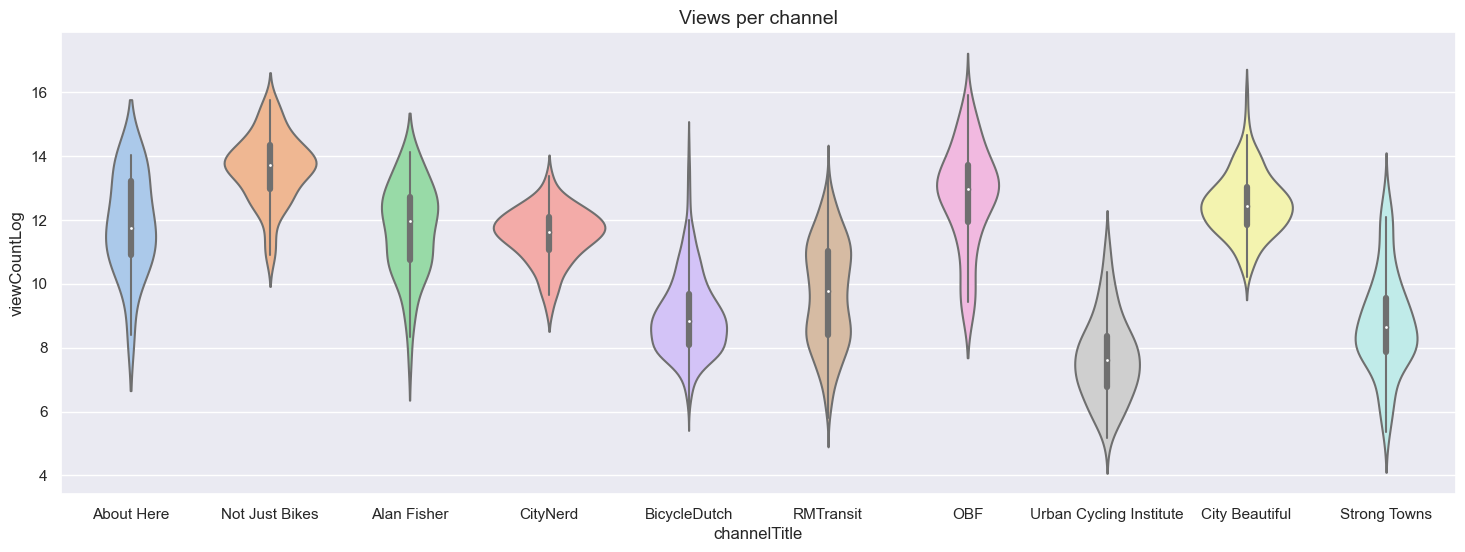

In [15]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x = 'channelTitle',y = 'viewCountLog', data = video_df,palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

<Axes: xlabel='likeCount', ylabel='viewCount'>

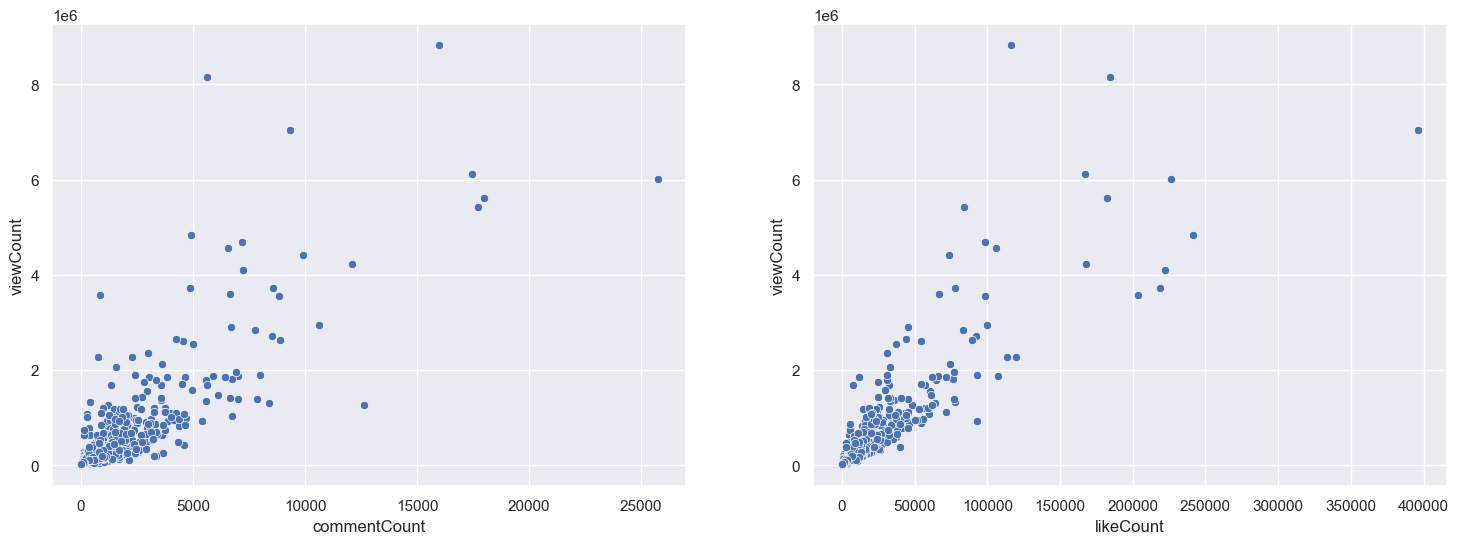

In [16]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<Axes: xlabel='likeRatio', ylabel='viewCount'>

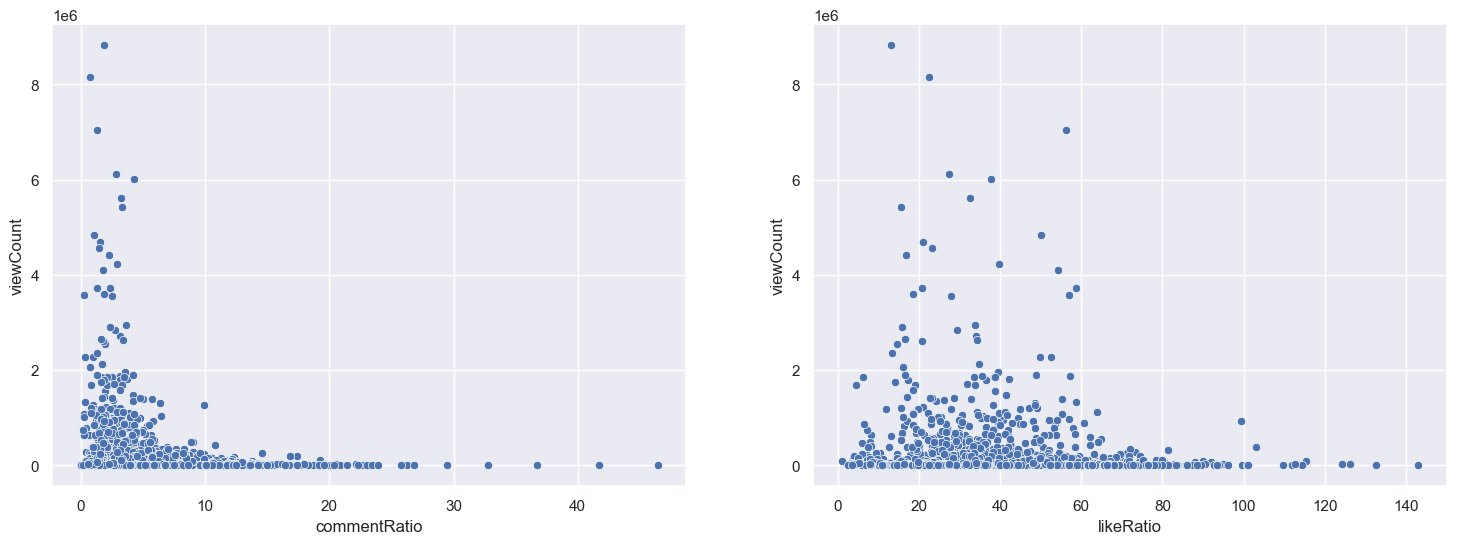

In [17]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some vides have very few views and have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relationship, we can still see some positive correlation between views and like ratio (though very subtle), which means that the more views a video has, the more people would hit the like button! This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.

#### Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 180 to 1000 seconds, which is about 3 to 17 minutes. I have decided to limit the duration to 5000 seconds because of some really long videos (such as livestreams) acting as outliers. Their numbers are too low to be statistically significant.

<Axes: xlabel='durationSec', ylabel='Count'>

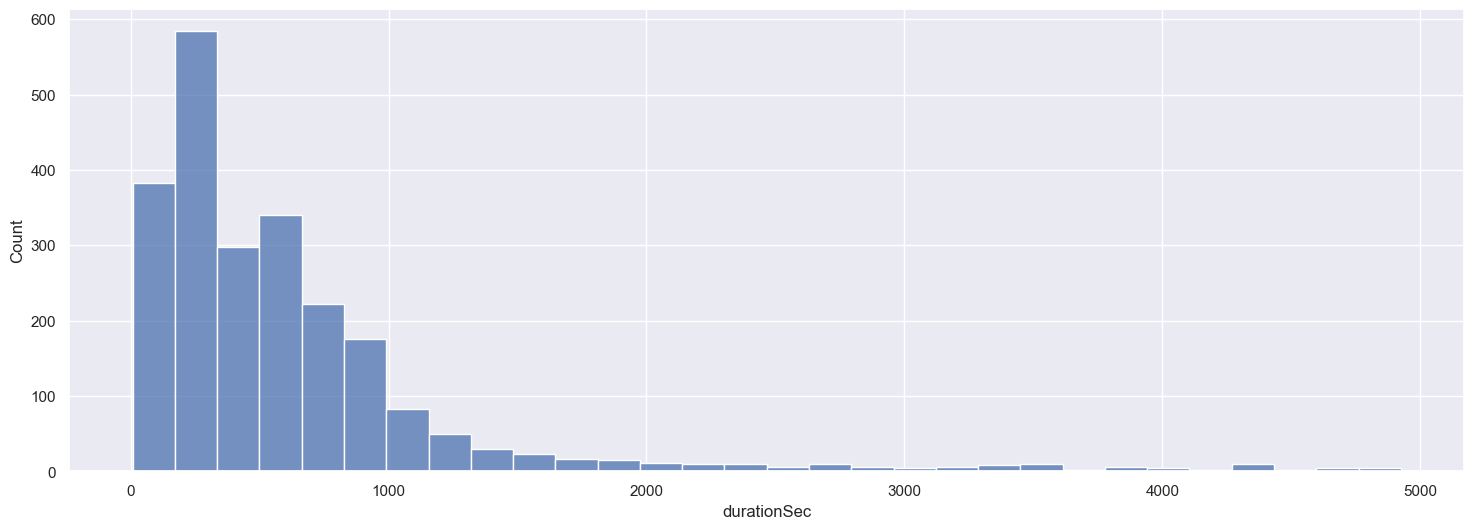

In [16]:
sns.histplot(data=video_df[video_df['durationSec'] < 5000], x="durationSec", bins=30)

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos. One possible reason is that people tend to quit watching longer videos and, therefore, less likely to interact with them through comments or likes.

<Axes: xlabel='durationSec', ylabel='likeCount'>

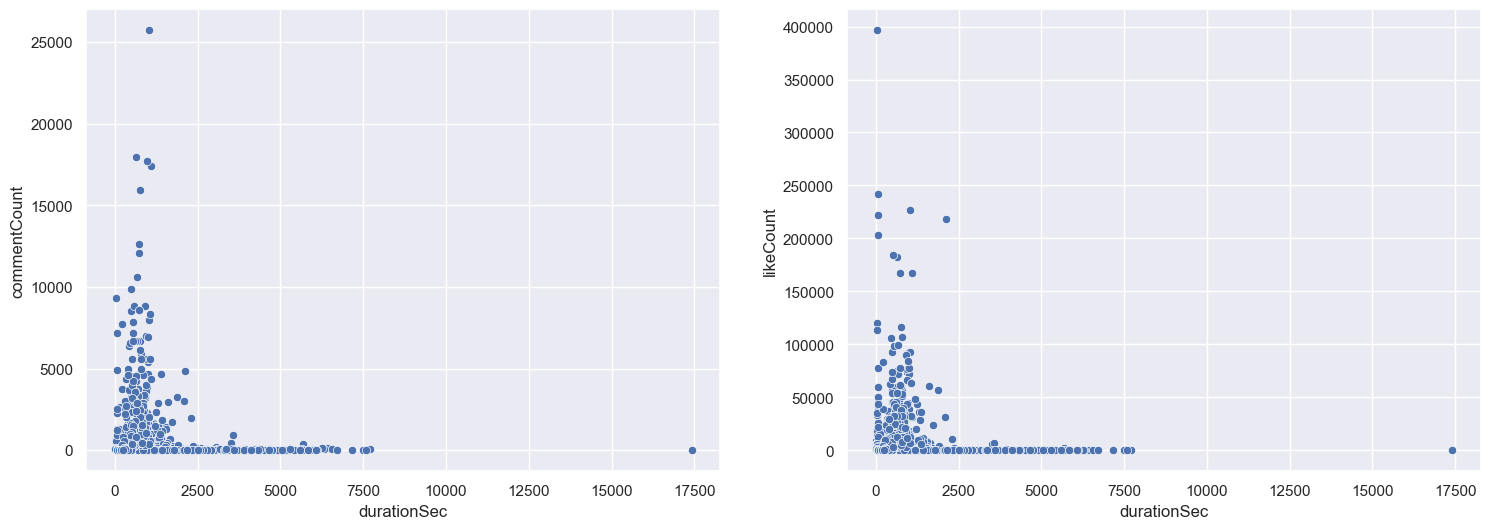

In [18]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSec", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSec", y = "likeCount", ax=ax[1])

### Does title length matter for views

The most-viewed videos tend to have average title length of 30-70 characters, although no clear relationship is present between the title length and views. We can see a rough normal distribution, suggesting that videos with titles which are too long or short have less views.

<Axes: xlabel='titleLength', ylabel='viewCount'>

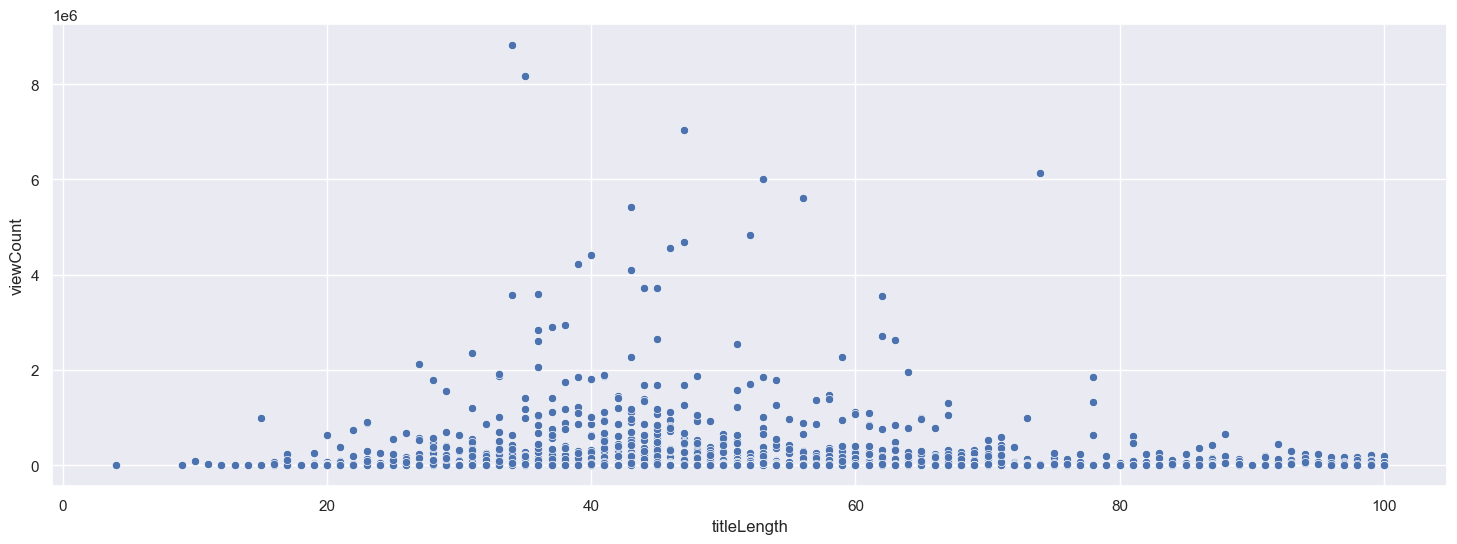

In [19]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

### Number of tags vs views

Many of the videos don't seem to make any use of tags. There seems to be a small negative correlation between the views and the tags, as too many tags seems to have fewer views.

<Axes: xlabel='tagsCount', ylabel='viewCount'>

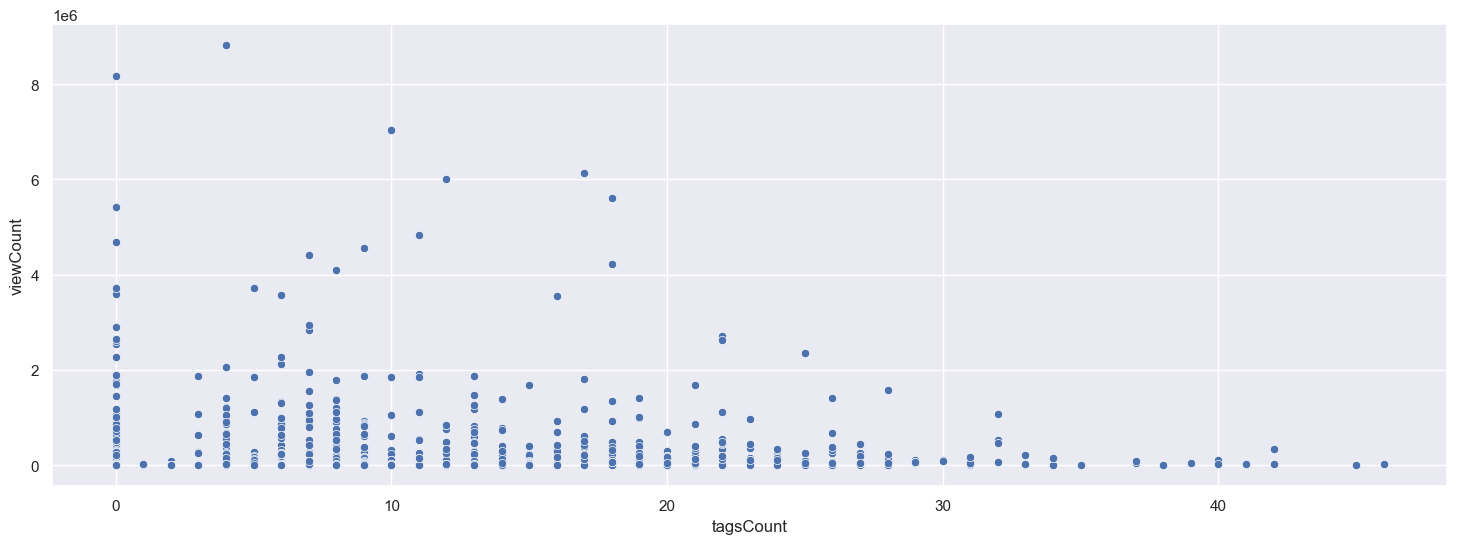

In [23]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

We can see that more videos get updated on Mondays or Tuesdays. Fewer videos are uploaded during the weekend. This might indicate that the creators work on their videos during the weekend and upload them during the first half of the week.    

Text(0.5, 1.0, 'Number of Videos Published by Day')

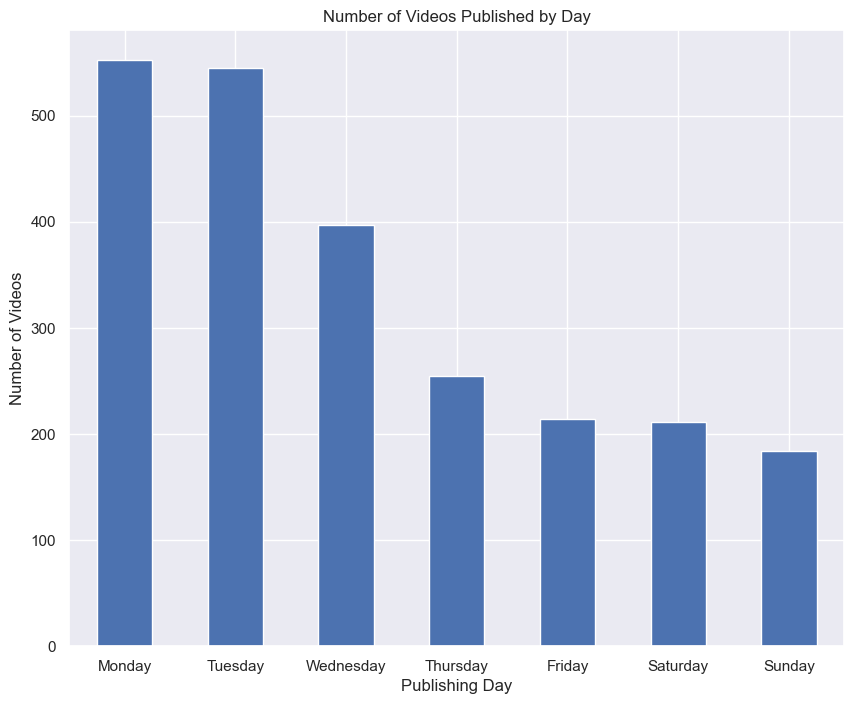

In [39]:
day_df = pd.DataFrame(video_df['publishDay'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x ='publishDay', y='count', rot=0, legend=False)

ax.set_xlabel("Publishing Day")
ax.set_ylabel("Number of Videos")
ax.set_title("Number of Videos Published by Day")


### Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you", "I", "the", etc. which do note contribute a lot to the meaning of the title.

In [20]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

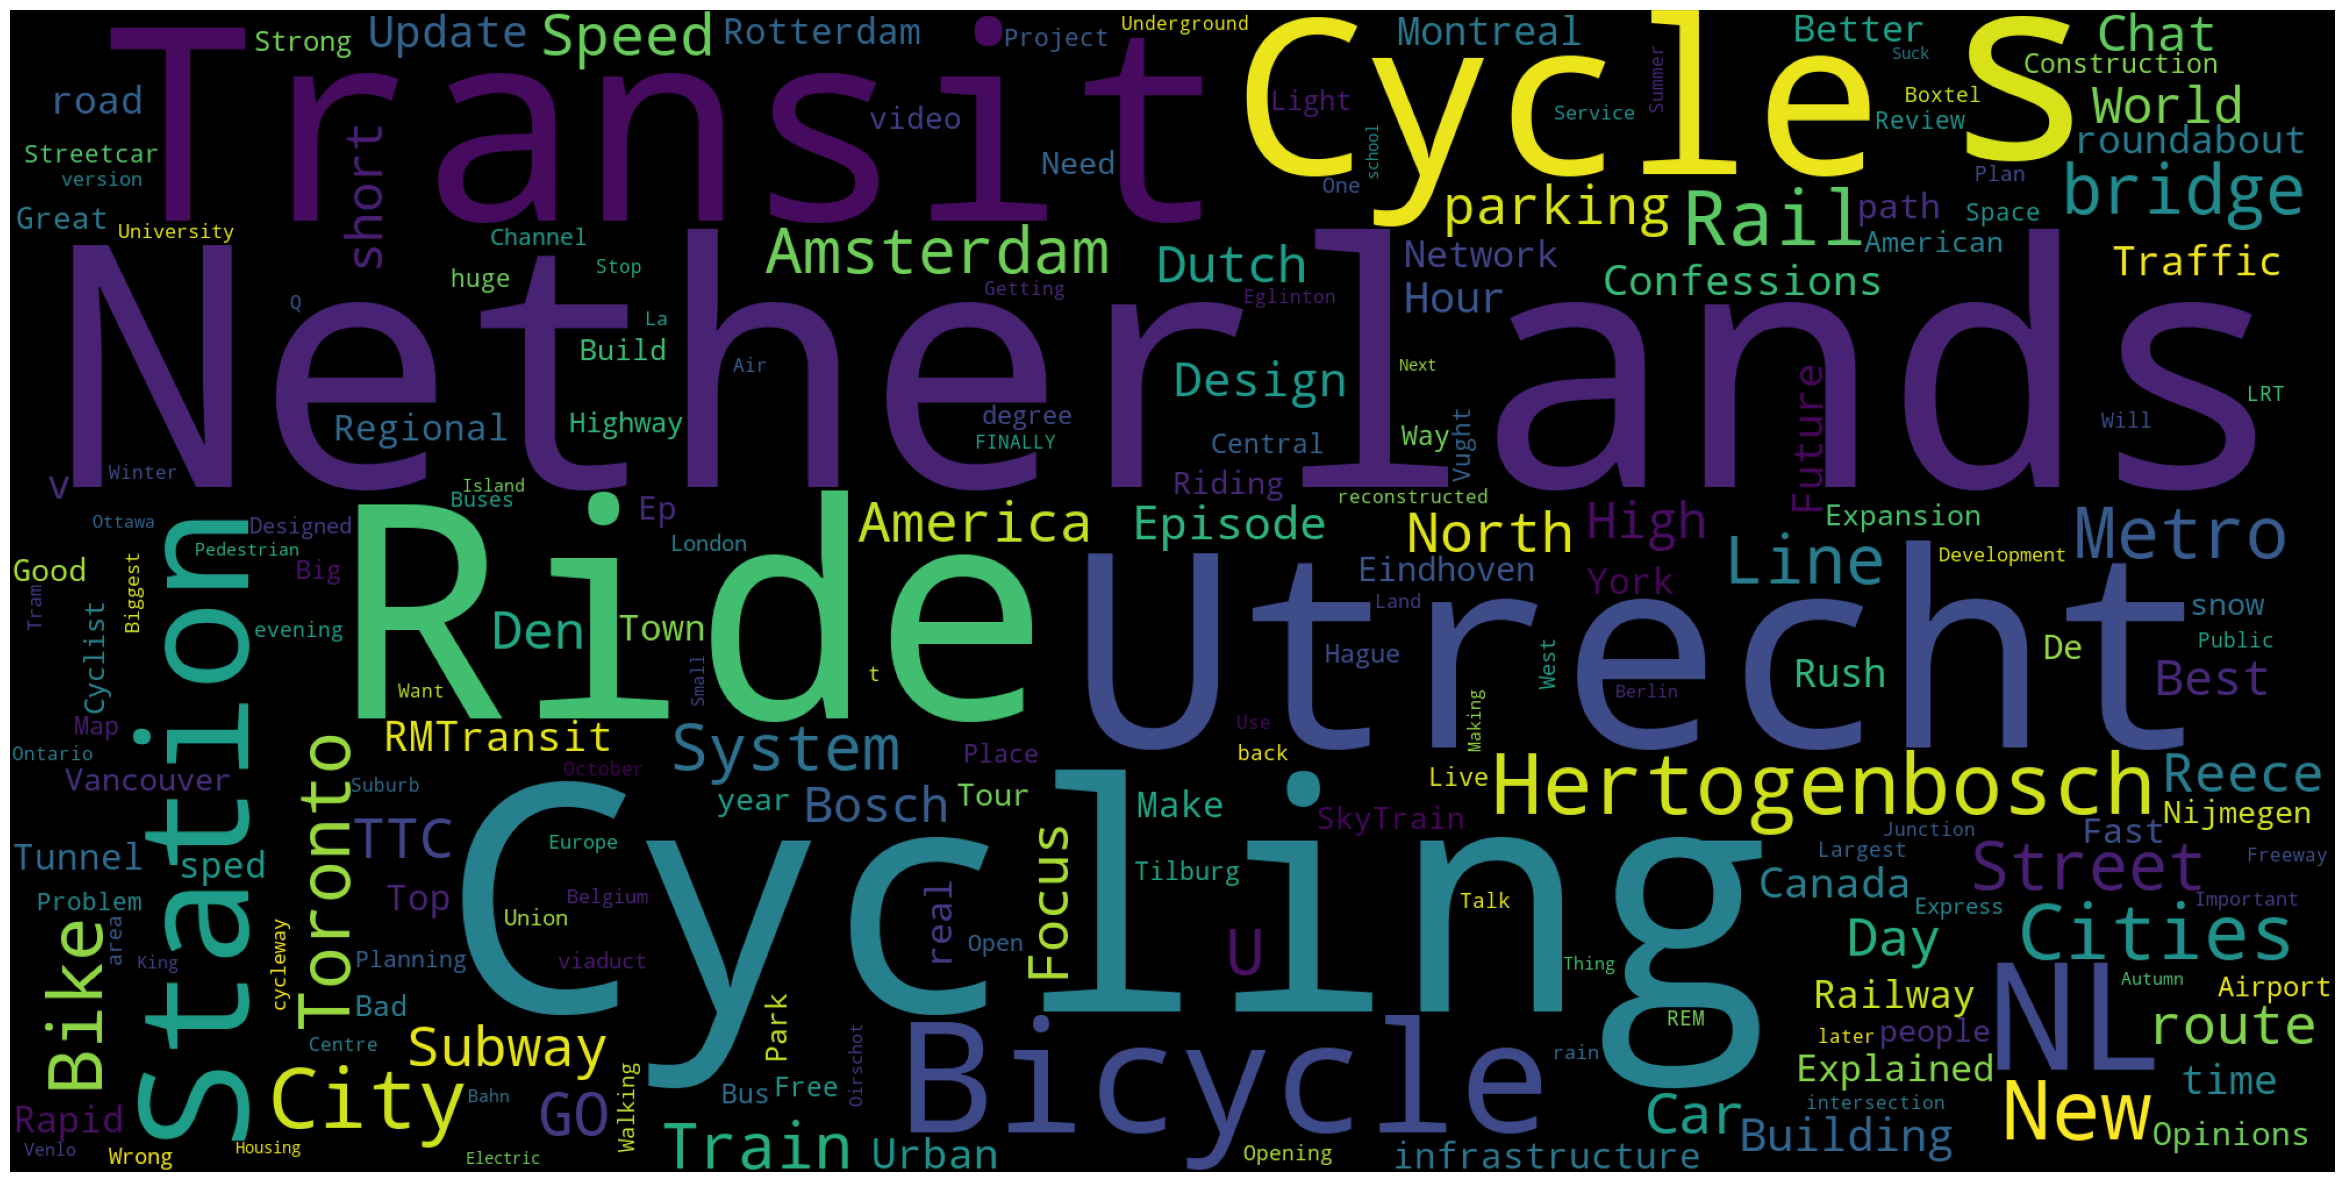

In [21]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

The most common words seem to be Cycling, Bicycle, Transit, Netherlands. It is worth noting, however, that some of the analysed channels are NL based. At the same time, the Netherlands are usually used as a best-practice example regarding biking infrastructure.

### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualising the keywords in a wordcloud.

In [25]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

<Figure size 1800x600 with 0 Axes>

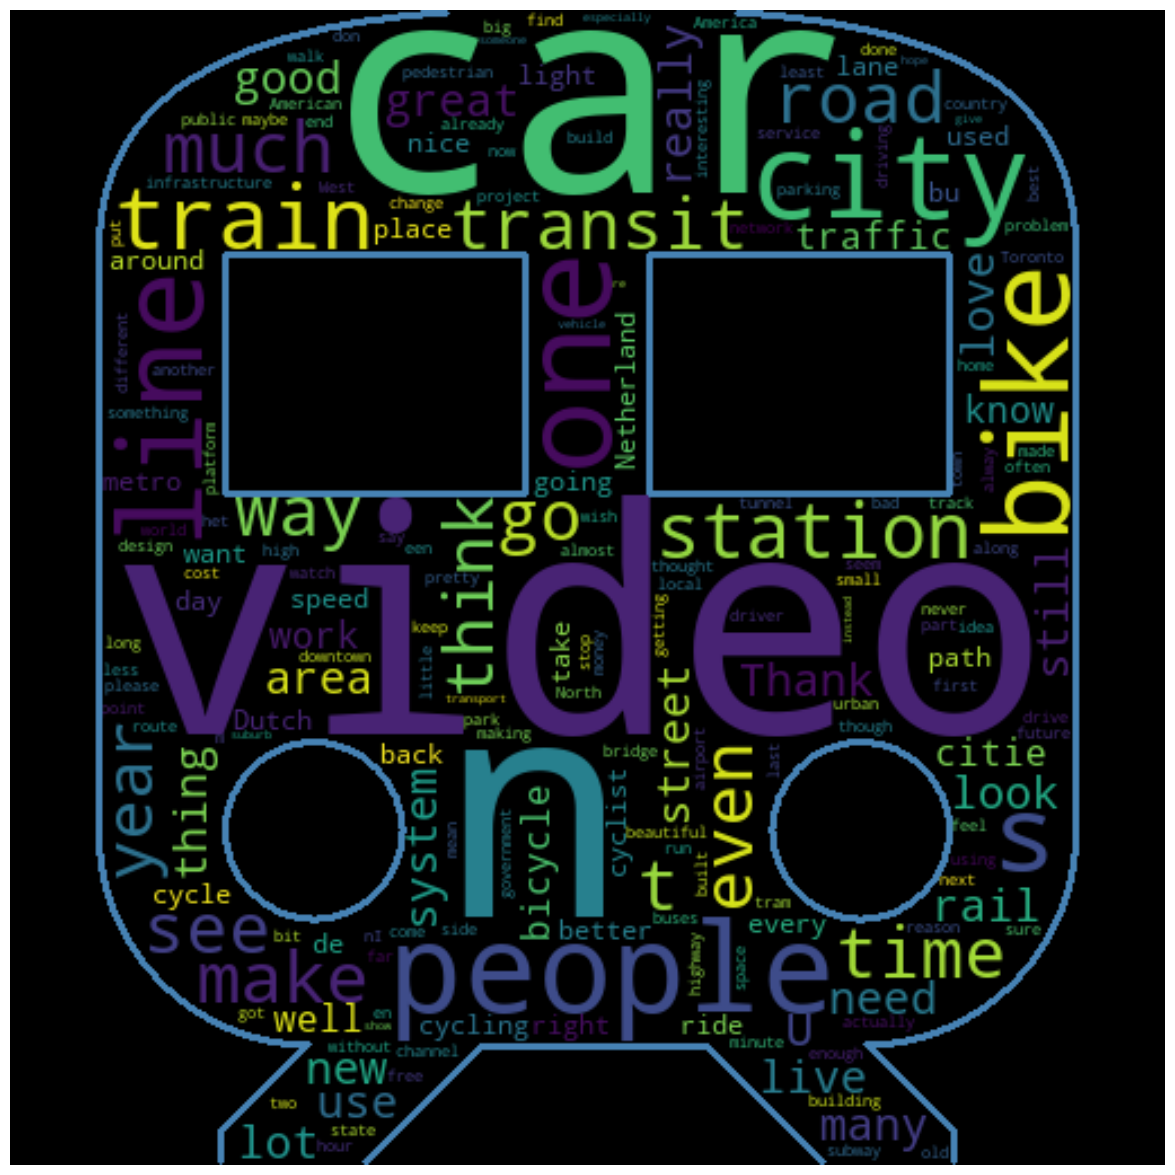

<Figure size 1800x600 with 0 Axes>

In [26]:
# A word cloud of the relevant words from the titles from the video of one channel

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
train_mask = np.array(Image.open(path.join(d, 'train_mask.png')))
    
wordcloud = WordCloud(width= 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False, mask=train_mask, contour_width=3, contour_color='steelblue').generate(all_words_str)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure()


We can see that next to the obvious words such as "video", "car", the most frequent words are all related to city infrastructure and public transport, such as "station", "train", "transit"

### Sentiment analysis from youtube comments

I've also decided to do sentiment analysis on the youtube comments. Such analysis can help us understand the type of engagement generally cultivated by the youtube channels.

For this task we'll use a deep-learning pretrained NLP classifier, specifically a RoBERTa model finetuned for sentiment analysis with the TweetEval benchmark. I've chosen this specific model because the finetuning is done on comments (tweets) similarly looking to a youtube comment. I've tested multiple BERT based models and concluded that this one has the best out-of-the-box performance.

In [1]:
from transformers import pipeline
from transformers import AutoTokenizer

In [4]:
sentiment_pipeline = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
token_limit  = 512

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


One limitation of the model is its token limit. All BERT-based transformer models have a fixed input size of 512 and some comments exceed this by a large margin. I've decided to remove those comments from analysis as truncating them may lead to a loss in context and therefore affect the accuracy of sentiment analysis. The number of such comments is not significant enough to warrant a more sophisticated solution.

In [6]:
sentiment_labels = []

for i in range(len(comments_df)):
    comments = parse_string_to_list(comments_df.iloc[i,1])
    filtered_comments = [comment for comment in comments if len(tokenizer.encode(comment)) <= token_limit]
    sentiment = sentiment_pipeline(filtered_comments)
    sentiment_labels.append(sentiment)

sentiment_labels = [item for sublist in sentiment_labels for item in sublist]
labels = [label['label'] for label in sentiment_labels]
labels_df = pd.DataFrame(labels)

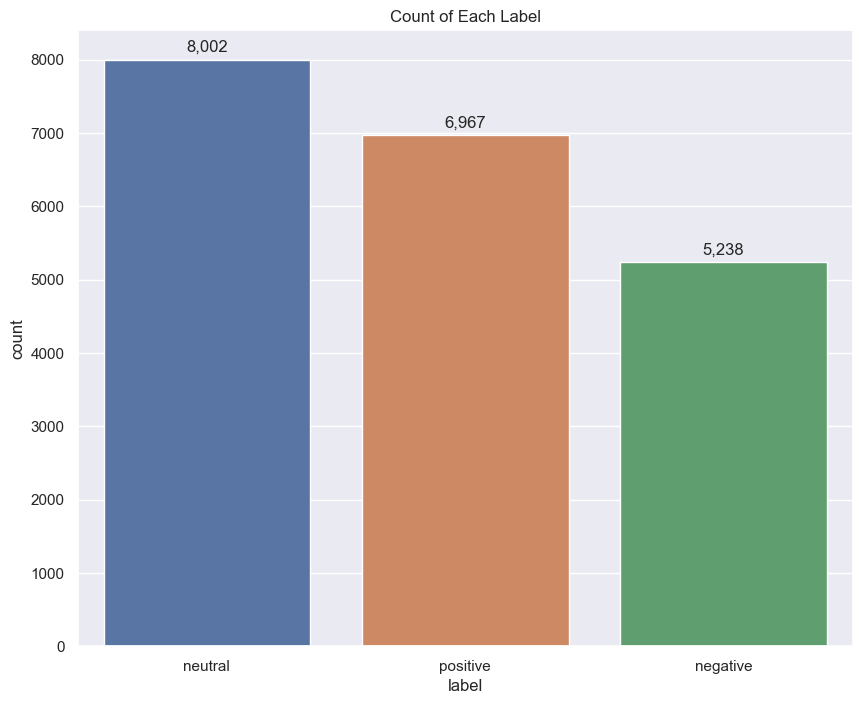

In [12]:
ax = sns.countplot(data=labels_df, x='label', order=labels_df['label'].value_counts().index)

# Annotate each bar with its count using the provided code
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Count of Each Label')
plt.show()

We can see that the majority of the comments are neutral, possibly because the user is debating a point from the video, explaining some of his personal experiences or simply asking a clarifying question. The label least used is the negative one, even though the number itself is relevant enough at 5238. Overall, the ratio of positive-neutral-negative comments suggest a healthy environment for debating and discussions, while the high number of positive comments indicate that the youtube channels are higher quality and the viewers generally appreciate the content.

## Conclusions and future research ideas

In this project, we have explored the video data of the 10 most popular City infrastructure channels and revealed many interesting findings for anyone who are starting out with a Youtube channel in data science or another topic:

- The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.

- Most videos have between 0 and 20 tags.

- Most-viewed videos tend to have average title length of 30-70 characters. Too short or too long titles seem to harm viewership.

- Videos are usually uploaded on Mondays and Tuesdays. Weekends and Sunday in particular is not a popular time for posting new videos.

- Comments on videos are generally either neutral or positive.

**Project limitation:**

The findings should also be taken with a grain of salt for a number of reasons:

- The number of videos is quite small (the dataset has only ~2,400 videos)

- I have only considered the first 10 comments on each video, which might not be representative for all comments.

- The sentiment analysis was done on all videos at once. It would be interesting the analyse the ratio on a per-channel basis.

- There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is.